# Assignment 6: Clustering
### Joe Leonard (ymd3tv) - DS 3001

**Q1.** This is a question about clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

In [1]:
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?

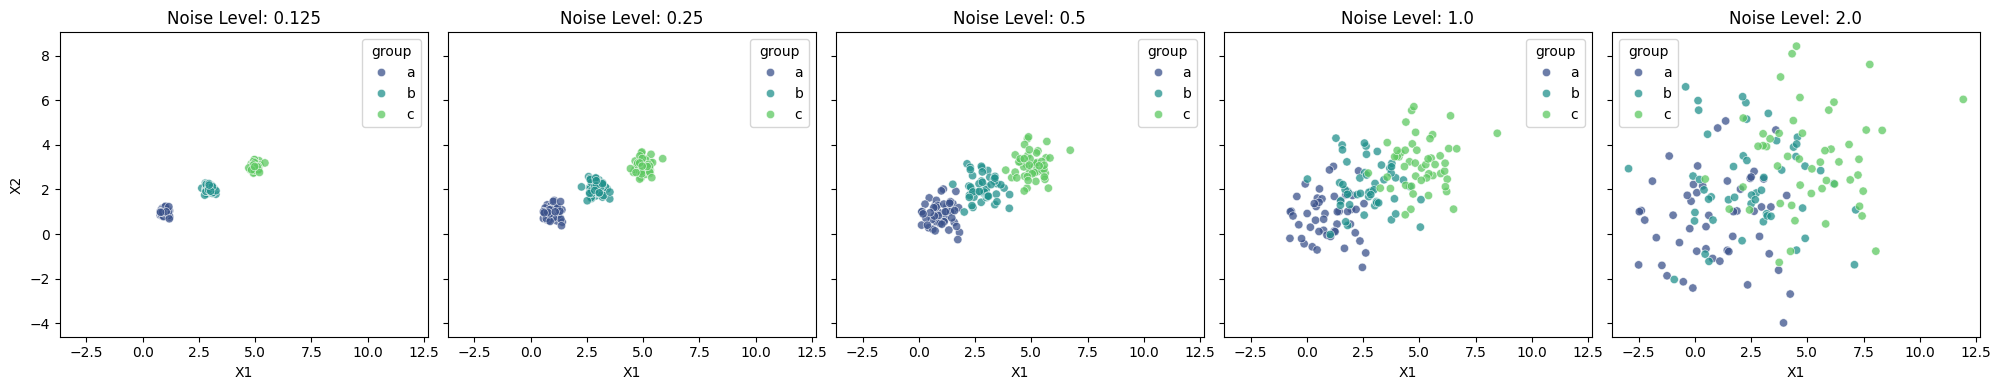

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Connecting Data to Noise Levels
dfs = [df0_125, df0_25, df0_5, df1_0, df2_0]
noise_levels = [0.125, 0.25, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, len(dfs), figsize=(20, 4), sharex=True, sharey=True)

for ax, df, noise in zip(axes, dfs, noise_levels):
    sns.scatterplot(data=df, x="x1", y="x2", hue="group", palette="viridis", alpha=0.75, ax=ax)
    ax.set_title(f"Noise Level: {noise}")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

plt.tight_layout()
plt.show()

As the noise level increases, we can see the data expand and become noisier and noisier. 

3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$. (Pay attention to the vertical axis across plots, or put all the scree curves on a single canvas.)

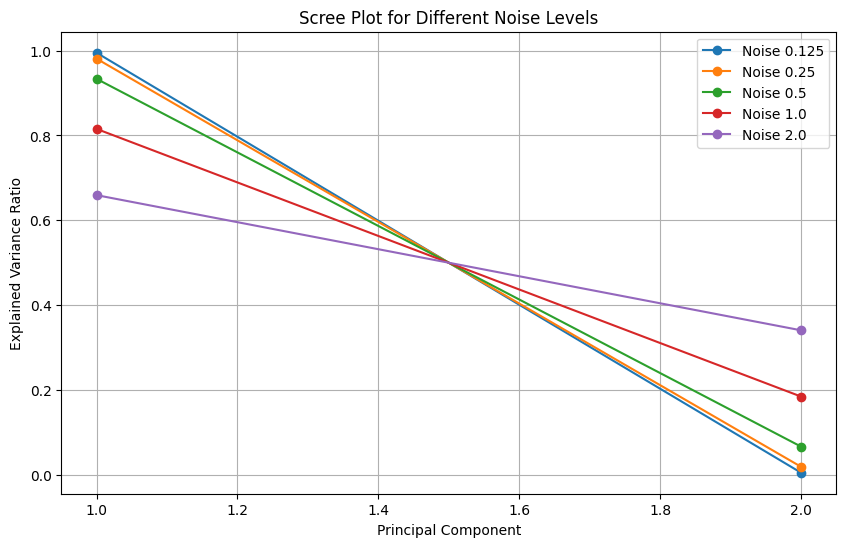

In [3]:
from sklearn.decomposition import PCA

plt.figure(figsize=(10, 6))

for df, noise in zip(dfs, noise_levels):
    X = df[['x1', 'x2']].values

    # Apply PCA
    pca = PCA()
    pca.fit(X)
    
    explained_variance = pca.explained_variance_ratio_

    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label=f"Noise {noise}")

# Formatting
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot for Different Noise Levels")
plt.legend()
plt.grid()
plt.show()

The higher the noise gets, the more straight the graph is and the more unclear and obvious the elbow is.

4. Explain the intuition of the elbow, using this numerical simulation as an example.

The elbow method is based on the idea that the optimal number of clusters is found where the explained variance starts to level off—forming an "elbow" in the scree plot. When noise is low, the first principal component captures most of the variance, creating a sharp drop in the scree plot, making the elbow distinct and easy to identify. As noise increases, variance is more evenly distributed across components, causing the scree plot to flatten, making the elbow less pronounced and making it harder to determine the optimal 
$k$. In the highest noise scenario, the lack of a clear elbow suggests that the data has no strong underlying structure, making clustering or dimensionality reduction less meaningful.

**Q2.** This question is a case study on clustering.

1. Load the `2022 election cycle fundraising.csv` file in the `./data` folder. This has campaign finance data for the 2022 election for House and Senate candidates. We're going to focus on the total amount they raised, `Raised`, the total amount they spent, `Spent`, their available `Cash on Hand`, and their `Debts`. The variables denominated in dollars are messy and require cleaning. How do you handle it?

In [4]:
import pandas as pd

# Loading the Data
elec_data = pd.read_csv("./data/2022 election cycle fundraising.csv")

# Columns to Clean
dollar_columns = ["Raised", "Spent", "Cash on Hand", "Debts"]

# Clean and Convert
for col in dollar_columns:
    elec_data[col] = elec_data[col].astype(str).str.replace("[\$,]", "", regex=True).astype(float)

print(elec_data[dollar_columns].describe())

             Raised         Spent  Cash on Hand         Debts
count  5.370000e+02  5.370000e+02  5.370000e+02  5.370000e+02
mean   3.592287e+06  2.875221e+06  1.790359e+06  1.268609e+05
std    7.376927e+06  6.332135e+06  2.804002e+06  8.426411e+05
min   -1.386356e+06  0.000000e+00 -6.478100e+04  0.000000e+00
25%    9.632370e+05  7.325080e+05  4.148470e+05  0.000000e+00
50%    1.731244e+06  1.239741e+06  9.592380e+05  0.000000e+00
75%    3.360517e+06  2.505998e+06  1.924564e+06  0.000000e+00
max    8.658147e+07  7.595981e+07  2.276298e+07  1.330200e+07


2. Max-min normalize `Raised` and `Spent`. Use a scree plot to determine the optimal number of clusters for the $k$ means clustering algorithm. Make a scatter plot of `Raised` against `Spent` and hue the dots by their cluster membership. What do you see? Which politicians comprise the smallest two clusters? If necessary, look up some of these races to see how close they were.

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the Scaler
scaler = MinMaxScaler()

# Normalize 'Raised' and 'Spent'
elec_data[['Raised_norm', 'Spent_norm']] = scaler.fit_transform(elec_data[['Raised', 'Spent']])

print(elec_data[['Raised', 'Spent', 'Raised_norm', 'Spent_norm']].head())


       Raised       Spent  Raised_norm  Spent_norm
0   7719396.0   7449678.0     0.103512    0.098074
1   2192741.0   1243502.0     0.040686    0.016371
2  20993041.0  13957854.0     0.254404    0.183753
3   1211111.0   1173466.0     0.029527    0.015449
4   1617611.0   1664674.0     0.034148    0.021915


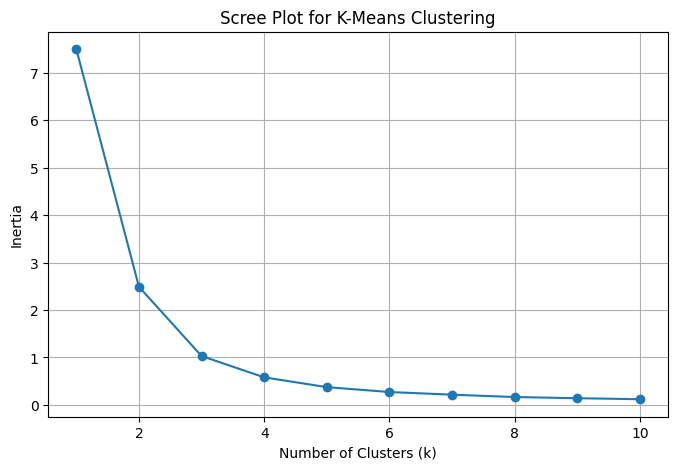

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(elec_data[['Raised_norm', 'Spent_norm']])
    inertia.append(kmeans.inertia_)

# Plot Scree
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Scree Plot for K-Means Clustering")
plt.grid()
plt.show()

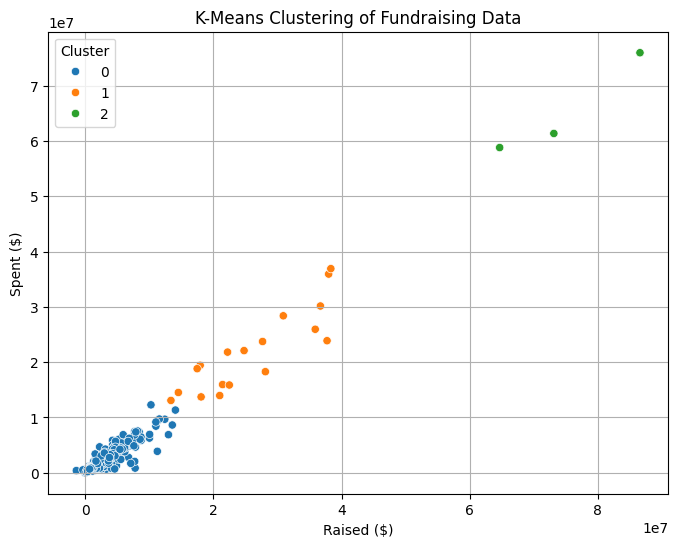

In [15]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
elec_data['cluster'] = kmeans.fit_predict(elec_data[['Raised_norm', 'Spent_norm']])

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=elec_data, x='Raised', y='Spent', hue=elec_data['cluster'].astype(str), palette='tab10')
plt.xlabel("Raised ($)")
plt.ylabel("Spent ($)")
plt.title("K-Means Clustering of Fundraising Data")
plt.legend(title="Cluster")
plt.grid()
plt.show()

In [16]:
cluster_counts = elec_data['cluster'].value_counts()
smallest_clusters = cluster_counts.nsmallest(2).index

# Get Candidates in the Smallest Cluster
smallest_cluster_candidates = elec_data[elec_data['cluster'].isin(smallest_clusters)][['Member', 'Raised', 'Spent', 'cluster']]
print(smallest_cluster_candidates)

                     Member      Raised       Spent  cluster
2               Adam Schiff  20993041.0  13957854.0        1
87   Catherine Cortez Masto  37993811.0  35928936.0        1
89            Chuck Schumer  35899966.0  25944350.0        1
115            Dan Crenshaw  14535870.0  14512435.0        1
261            John Kennedy  28119082.0  18276565.0        1
290            Katie Porter  21441693.0  15946876.0        1
298          Kevin McCarthy  24791538.0  22086344.0        1
326           Maggie Hassan  30914830.0  28380992.0        1
328             Marco Rubio  36709285.0  30153111.0        1
340              Mark Kelly  73140886.0  61357281.0        2
357          Michael Bennet  18086343.0  13713611.0        1
390            Nancy Pelosi  22216583.0  21814643.0        1
402            Patty Murray  13377243.0  13073248.0        1
414               Rand Paul  22490627.0  15865010.0        1
417         Raphael Warnock  86581469.0  75959810.0        2
442             Ron John

3. Repeat part 2, but for `Cash on Hand` and `Debts`. Compare your results with part 2. Why might this be? If necessary, look up some of these races to see how close they were.

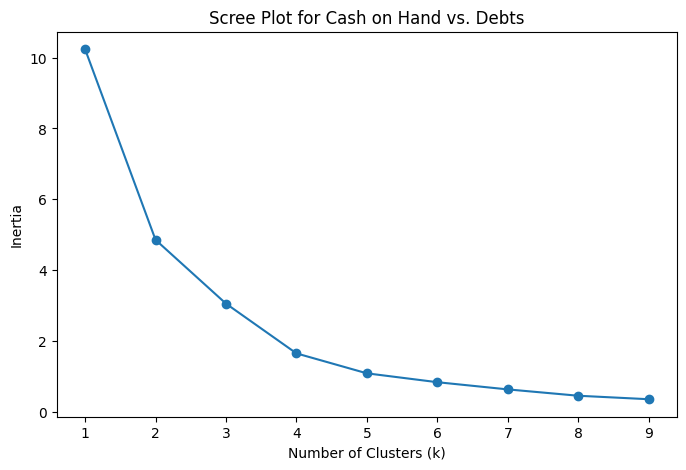

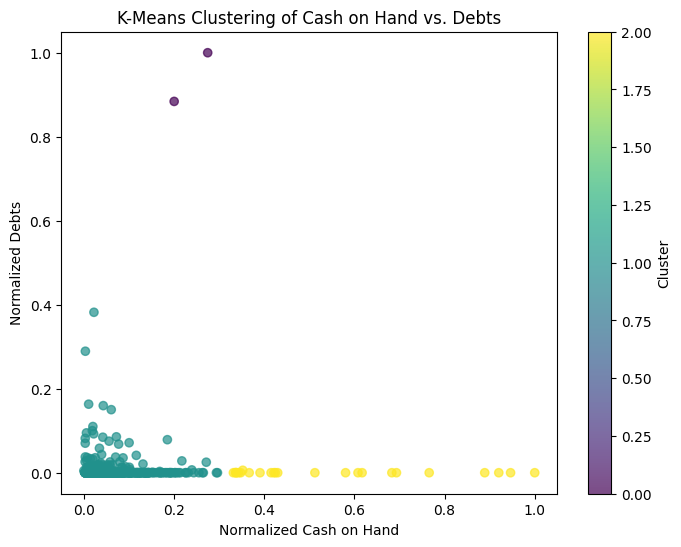

In [ ]:
# Normalize 'Cash on Hand' and 'Debts'
scaler = MinMaxScaler()
elec_data[['Cash_norm', 'Debts_norm']] = scaler.fit_transform(elec_data[['Cash on Hand', 'Debts']])

# Scree Plot
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(elec_data[['Cash_norm', 'Debts_norm']])
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Scree Plot for Cash on Hand vs. Debts')
plt.show()

# Apply K-Means
optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
elec_data['Cluster_CD'] = kmeans.fit_predict(elec_data[['Cash_norm', 'Debts_norm']])

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(elec_data['Cash_norm'], elec_data['Debts_norm'], c=elec_data['Cluster_CD'], cmap='viridis', alpha=0.7)
plt.xlabel('Normalized Cash on Hand')
plt.ylabel('Normalized Debts')
plt.title('K-Means Clustering of Cash on Hand vs. Debts')
plt.colorbar(label='Cluster')
plt.show()


4. Use $k$ means clustering with all four numeric variables. How do your results compare to the previous two parts?

[[ 1.26794682  1.0635113   2.47825788  0.39415495]
 [-0.19495504 -0.18260578 -0.21562283 -0.04902929]
 [ 5.88542509  5.88497356  3.28168108  1.25429061]]


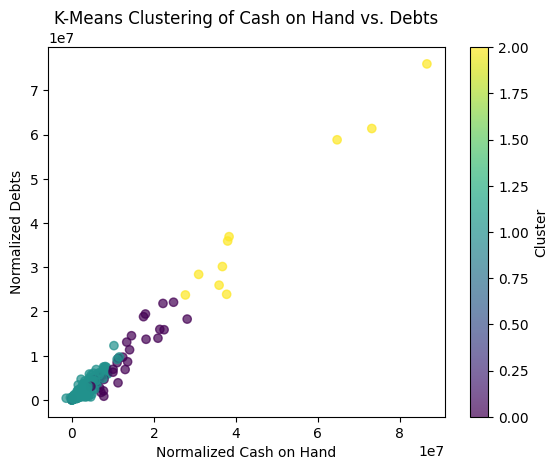

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
elec_data_scaled = scaler.fit_transform(elec_data[["Raised", "Spent", "Cash on Hand", "Debts"]])

kmeans = KMeans(n_clusters=3)
kmeans.fit(elec_data_scaled)
labels = kmeans.labels_

print(kmeans.cluster_centers_)
elec_data['Cluster'] = labels

plt.scatter(elec_data['Raised'], elec_data['Spent'], c=elec_data['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Normalized Cash on Hand')
plt.ylabel('Normalized Debts')
plt.title('K-Means Clustering of Cash on Hand vs. Debts')
plt.colorbar(label='Cluster')

# Show the plot
plt.show()


Since we are adding in two more variables, we can see that the data is getting clouded within the clustering and points that were originally cluster 1 have now become cluster 2 thanks to the addition of two more variables in our analysis.

5. Did the $k$-MC algorithm find useful patterns for you in analyzing the election?

Yes, I think this method is really helpful in pointing out which data points are similar to each other based on their values and can see hw this would be helpful in a grouping or clustering analysis.